# BigQuery Data for TensorFlow Train and Save then AI Platform for Serving

Prepare TensorFlow

In [219]:
from tensorflow_io.bigquery import BigQueryClient
from tensorflow_io.bigquery import BigQueryReadSession
import tensorflow as tf

Setup Parameters

In [220]:
PROJECT_ID='statmike-mlops'
BQDATASET_ID='digits'
BQTABLE_ID='digits_prepped'
MODEL_DIR='gs://statmike-models/digits/keras'
BATCH_SIZE = 30

Retrieve the Schema info from BigQuery Information Schema via the Storage API:
- https://cloud.google.com/bigquery/docs/bigquery-storage-python-pandas

In [221]:
from google.cloud import bigquery
bqclient = bigquery.Client()
bqjob = bqclient.query(
"""
SELECT * FROM `"""+BQDATASET_ID+""".INFORMATION_SCHEMA.COLUMN_FIELD_PATHS`
WHERE TABLE_NAME = '"""+BQTABLE_ID+"""' """
)
schema = bqjob.result().to_dataframe()
schema

,table_catalog,table_schema,table_name,column_name,field_path,data_type,description
0,statmike-mlops,digits,digits_prepped,p0,p0,FLOAT64,None
1,statmike-mlops,digits,digits_prepped,p1,p1,FLOAT64,None
2,statmike-mlops,digits,digits_prepped,p2,p2,FLOAT64,None
3,statmike-mlops,digits,digits_prepped,p3,p3,FLOAT64,None
4,statmike-mlops,digits,digits_prepped,p4,p4,FLOAT64,None
...,...,...,...,...,...,...,...
62,statmike-mlops,digits,digits_prepped,p62,p62,FLOAT64,None
63,statmike-mlops,digits,digits_prepped,p63,p63,FLOAT64,None
64,statmike-mlops,digits,digits_prepped,target,target,INT64,None
65,statmike-mlops,digits,digits_prepped,target_OE,target_OE,STRING,None


Use the the table schema to prepare the TensorFlow Model:
- Omit unused columns
- Create feature_columns for the model
- Define the dtypes for TensorFlow

In [222]:
OMIT = ['target_OE','SPLITS']

selected_fields=schema[~schema.column_name.isin(OMIT)].column_name.tolist()

feature_columns = []
feature_layer_inputs = {}
for header in selected_fields:
    if header != 'target':
        feature_columns.append(tf.feature_column.numeric_column(header))
        feature_layer_inputs[header] = tf.keras.Input(shape=(1,),name=header)

from tensorflow.python.framework import dtypes
output_types=schema[~schema.column_name.isin(OMIT)].data_type.tolist()
output_types = [dtypes.float64 if x=='FLOAT64' else dtypes.int64 for x in output_types]

Define a function that remaps the input data for TensorFlow into features, target and one_hot encodes the target:

In [223]:
def transTable(row_dict):
    target=row_dict.pop('target')
    target = tf.one_hot(tf.cast(target,tf.int64),10)
    target = tf.cast(target,tf.float32)
    return(row_dict,target)

Setup TensorFlow_IO client > session > table + table.map
- https://www.tensorflow.org/io/api_docs/python/tfio/bigquery/BigQueryClient

In [224]:
client = BigQueryClient()
session = client.read_session("projects/"+PROJECT_ID,PROJECT_ID,BQTABLE_ID,BQDATASET_ID,selected_fields,output_types,row_restriction="SPLITS='TRAIN'",requested_streams=3)
table = session.parallel_read_rows()
table = table.map(transTable)
train = table.shuffle(100000).batch(BATCH_SIZE)

In [225]:
client = BigQueryClient()
session = client.read_session("projects/"+PROJECT_ID,PROJECT_ID,BQTABLE_ID,BQDATASET_ID,selected_fields,output_types,row_restriction="SPLITS='TEST'",requested_streams=3)
table = session.parallel_read_rows()
table = table.map(transTable)
test = table.batch(BATCH_SIZE)

Review a single batch of the train data:

In [226]:
for a, b in train.take(1):
    columns=list(a.keys())
    print(columns)
    #print(a)
    print(b)

['p0', 'p1', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p2', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p3', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p4', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p5', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p6', 'p60', 'p61', 'p62', 'p63', 'p7', 'p8', 'p9']
tf.Tensor(
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.

Define the Model:

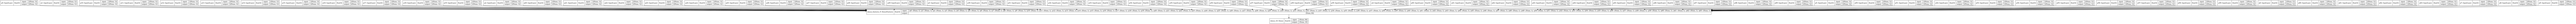

In [227]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
feature_layer_outputs = feature_layer(feature_layer_inputs)
model = tf.keras.Model(inputs=[v for v in feature_layer_inputs.values()],outputs=tf.keras.layers.Dense(10,activation=tf.nn.softmax)(feature_layer_outputs))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model,show_shapes=True, show_dtype=True)

Fit the Model:

In [228]:
history = model.fit(train,epochs=25)

Epoch 1/25
49/49 [==============================] - 3s 10ms/step - loss: 6.2248 - accuracy: 0.3337
Epoch 2/25
49/49 [==============================] - 1s 7ms/step - loss: 0.7040 - accuracy: 0.8132
Epoch 3/25
49/49 [==============================] - 1s 9ms/step - loss: 0.3572 - accuracy: 0.8979
Epoch 4/25
49/49 [==============================] - 1s 9ms/step - loss: 0.3026 - accuracy: 0.9074
Epoch 5/25
49/49 [==============================] - 1s 9ms/step - loss: 0.2142 - accuracy: 0.9350
Epoch 6/25
49/49 [==============================] - 1s 8ms/step - loss: 0.1871 - accuracy: 0.9461
Epoch 7/25
49/49 [==============================] - 1s 7ms/step - loss: 0.1546 - accuracy: 0.9517
Epoch 8/25
49/49 [==============================] - 1s 9ms/step - loss: 0.1789 - accuracy: 0.9437
Epoch 9/25
49/49 [==============================] - 1s 9ms/step - loss: 0.1247 - accuracy: 0.9597
Epoch 10/25
49/49 [==============================] - 1s 6ms/step - loss: 0.1262 - accuracy: 0.9606
Epoch 11/25
49/49 

Evaluate the model with the test data:

In [229]:
loss, accuracy = model.evaluate(test)

12/12 [==============================] - 2s 10ms/step - loss: 0.1685 - accuracy: 0.9528


Create Prediction from a batch of the test data:

In [230]:
model.predict(test.take(1))

array([[9.99899268e-01, 1.69382474e-06, 3.38389095e-09, 1.31937017e-09,
        2.88740393e-05, 4.13479455e-08, 3.98502416e-05, 1.56108470e-07,
        2.85425176e-05, 1.64770915e-06],
       [9.98845935e-01, 2.56355975e-06, 1.65660003e-06, 4.36377796e-08,
        1.45144767e-08, 1.52086326e-08, 1.13523600e-03, 7.97718211e-11,
        3.11524360e-07, 1.41973751e-05],
       [9.01308000e-01, 6.23430878e-06, 5.17169241e-08, 8.98554653e-09,
        3.21628164e-07, 2.31329565e-07, 9.86706913e-02, 2.03016692e-09,
        2.83667373e-06, 1.16986521e-05],
       [3.35446656e-01, 1.35091238e-03, 1.13102885e-07, 1.00709050e-11,
        6.63178682e-01, 1.26815351e-07, 1.98714661e-05, 3.24131179e-06,
        3.92393048e-07, 2.07571347e-08],
       [9.99741614e-01, 2.23971295e-08, 4.40060965e-09, 4.60071391e-12,
        2.07315750e-07, 1.68776921e-08, 2.57978507e-04, 2.19437232e-10,
        1.12247776e-08, 7.57712613e-08],
       [5.41142064e-09, 9.51893926e-01, 8.86578644e-10, 1.47939718e-05,
   

Save the model:

In [231]:
model.save(MODEL_DIR)

INFO:tensorflow:Assets written to: gs://statmike-models/digits/keras/assets


# Serve the model for online prediction

In [232]:
MODEL_NAME='KERAS-DIGITS'
ENDPOINT_NAME='DIGITS2'
FRAMEWORK='TENSORFLOW'
params = {"MODEL_DIR":MODEL_DIR}
REGION='us-central1'
CONTAINER_URI='us-docker.pkg.dev/cloud-aiplatform/prediction/tf2-cpu.2-2:latest'

In [233]:
!gcloud beta ai models upload --region=$REGION --display-name=$MODEL_NAME --container-image-uri=$CONTAINER_URI --artifact-uri=$MODEL_DIR

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [6407169814887923712]...done.                            


In [234]:
!gcloud beta ai models list --region=$REGION --filter=display_name=$MODEL_NAME

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
---
artifactUri: gs://statmike-models/digits/keras
containerSpec:
  imageUri: us-docker.pkg.dev/cloud-aiplatform/prediction/tf2-cpu.2-2:latest
createTime: '2021-04-06T13:44:57.012757Z'
displayName: KERAS-DIGITS
etag: AMEw9yOXVCKdRODTSz0tgaikU4xS0NDKVmvxfCn9_T_9ukFOEPllqVmGoHKspeMwlWKj
name: projects/691911073727/locations/us-central1/models/862668027060027392
predictSchemata: {}
supportedDeploymentResourcesTypes:
- DEDICATED_RESOURCES
supportedExportFormats:
- exportableContents:
  - ARTIFACT
  id: custom-trained
supportedInputStorageFormats:
- jsonl
- csv
- tf-record
- tf-record-gzip
- file-list
supportedOutputStorageFormats:
- jsonl
updateTime: '2021-04-06T13:45:15.632288Z'


In [235]:
MODEL_ID=862668027060027392

In [236]:
!gcloud beta ai endpoints create --region=$REGION --display-name=$ENDPOINT_NAME

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [4811769646891925504]...done.                            
Created AI Platform endpoint: projects/691911073727/locations/us-central1/endpoints/8396134672488202240.


In [237]:
ENDPOINT_ID=8396134672488202240

In [238]:
!gcloud beta ai endpoints deploy-model $ENDPOINT_ID --region=$REGION --model=$MODEL_ID --display-name=$MODEL_NAME --traffic-split=0=100

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [106633936196599808]...done.                             
Deployed a model to the endpoint 8396134672488202240. Id of the deployed model: 2396354806412214272.


In [239]:
DMODEL_ID=2396354806412214272

In [240]:
!gcloud beta ai endpoints predict $ENDPOINT_ID --region=$REGION --json-request=newob.json

Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[[0.999824822, 4.77362261e-10, 2.66572351e-06, 1.25705867e-07, 7.19129559e-07, 9.0702606e-06, 0.000146288061, 1.02650304e-07, 1.52299856e-06, 1.46506063e-05]]


# Remove Resources
- undeploy-model
- remove endpoint
- remove model

In [ ]:
!gcloud beta ai endpoints describe $ENDPOINT_ID --region=$REGION

In [ ]:
!gcloud beta ai endpoints undeploy-model $ENDPOINT_ID --region=$REGION --deployed-model-id=$DMODEL_ID

In [ ]:
!echo "Y" | gcloud beta ai endpoints delete $ENDPOINT_ID --region=$REGION

In [ ]:
!gcloud beta ai models delete $MODEL_ID --region=$REGION

In [203]:
!gsutil rm -r $MODEL_DIR

Removing gs://statmike-models/digits/keras/#1617663061696426...
Removing gs://statmike-models/digits/keras/assets/#1617663064722256...          
Removing gs://statmike-models/digits/keras/saved_model.pb#1617663065086705...   
Removing gs://statmike-models/digits/keras/variables/#1617663061897932...       
/ [4 objects]                                                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m rm ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Removing gs://statmike-models/digits/keras/variables/variables.data-00000-of-00001#1617663063733934...
Removing gs://statmike-models/digits/keras/variables/variables.index#1617663064026656...
/ [6 objects]                                                                   
Operation completed over 6 objects.                                              
